# Fine-tuning VGG19

This is based on section 5.3 *Using a pretrained convnet* of the book *Deep learning with Python* by Francois Chollet. I have made several changes to the code. I use the data that is already provided by Google. I don't download the data from Kaggle as in the deep learning book.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-17 20:13:48--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  71.5MB/s    in 0.9s    

2019-04-17 20:13:49 (71.5 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import os
import zipfile
from google.colab import files

from keras.applications import VGG19
from keras import layers
from keras import models
from keras import optimizers
from keras.regularizers import l1
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
import matplotlib.pyplot as plt

from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Using TensorFlow backend.


In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Load the convolutional base and freeze it

In [4]:
conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

conv_base.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


## Create model to put on top of VGG19

This model contains densely connected layers that will use the features extracted from the convolutional base to classify images as either cats or dogs.  Because these models suffer greatly from overfitting, we use a high drop out rate for the dense layer, as well decreasing the size of the dense layer in order to reduce the complexity of the model and further fight overfitting.  Also added is L1-Regularization, which helps against overfitting by emphasizing features that are important in classification and penalizing those that are not.

In [5]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01)))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 21,073,217
Trainable params: 1,048,833
Non-trainable params: 20,024,384
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [7]:
batches = 32
val_steps = int(1000/batches)
train_steps = int(2000/batches)

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.Adam(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=val_steps
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
62/62 [==============================] - 20s 327ms/step - loss: 138.3939 - acc: 0.5277 - val_loss: 135.2233 - val_acc: 0.6270
Epoch 2/40
62/62 [==============================] - 18s 287ms/step - loss: 132.2898 - acc: 0.5640 - val_loss: 129.1917 - val_acc: 0.6643
Epoch 3/40
62/62 [==============================] - 16s 263ms/step - loss: 126.3352 - acc: 0.5675 - val_loss: 123.3040 - val_acc: 0.6808
Epoch 4/40
62/62 [==============================] - 16s 260ms/step - loss: 120.5053 - acc: 0.6008 - val_loss: 117.5433 - val_acc: 0.7231
Epoch 5/40
62/62 [==============================] - 16s 266ms/step - loss: 114.8233 - acc: 0.5968 - val_loss: 111.9308 - val_acc: 0.7262
Epoch 6/40
62/62 [==============================] - 16s 260ms/step - loss: 109.2849 - acc: 0.5988 - val_loss: 106.4596 - val_acc: 0.7045
Epoch 7/40
62/62 [============================

## Display curves of loss and accuracy during training

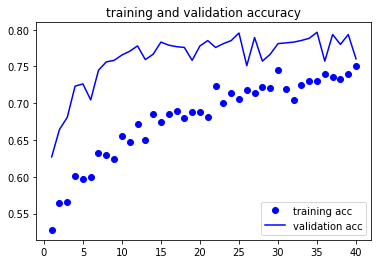

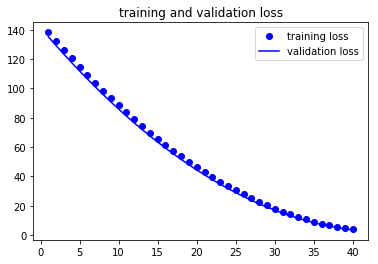

In [8]:

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [0]:
conv_base.trainable = True

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    layer.trainable = True

In [0]:
def lr_schedule(epoch):
  
  lr = 1e-5
  
  if epoch > 75:
      lr *= 1e-3
  elif epoch > 50:
      lr *= 1e-2
  elif epoch > 25:
      lr *= 1e-1
  return lr

In [11]:
# compile model
import numpy as np
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(lr=lr_schedule(0)), 
    metrics=['acc'])

model_type = "VGG19"
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=1e-8)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=val_steps,
    workers=4,
    callbacks=callbacks)

Epoch 1/100
62/62 [==============================] - 28s 450ms/step - loss: 3.0430 - acc: 0.8256 - val_loss: 2.6956 - val_acc: 0.8688

Epoch 00001: val_acc improved from -inf to 0.86880, saving model to /content/saved_models/cifar10_VGG19_model.001.h5
Epoch 2/100
62/62 [==============================] - 20s 322ms/step - loss: 2.4644 - acc: 0.8775 - val_loss: 2.1441 - val_acc: 0.9287

Epoch 00002: val_acc improved from 0.86880 to 0.92872, saving model to /content/saved_models/cifar10_VGG19_model.002.h5
Epoch 3/100
62/62 [==============================] - 20s 324ms/step - loss: 2.0085 - acc: 0.9289 - val_loss: 1.8378 - val_acc: 0.9411

Epoch 00003: val_acc improved from 0.92872 to 0.94112, saving model to /content/saved_models/cifar10_VGG19_model.003.h5
Epoch 4/100
62/62 [==============================] - 20s 326ms/step - loss: 1.7904 - acc: 0.9289 - val_loss: 1.7669 - val_acc: 0.9122

Epoch 00004: val_acc did not improve from 0.94112
Epoch 5/100
62/62 [==============================] - 

## Display learning curves during fine-tuning

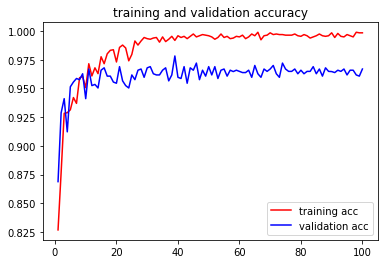

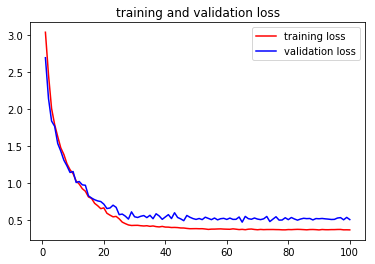

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'r', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'r', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [13]:
!ls /content/saved_models/ | tail -1

cifar10_VGG19_model.039.h5


In [0]:
cp /content/saved_models/cifar10_VGG19_model.039.h5 /content/VGG19_P2_best.h5

## Print out validation loss and accuracy

In [0]:
from keras.models import load_model

model = load_model('VGG19_P2_best.h5')
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=val_steps)

In [26]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.551405395358062
Validation accuracy: 0.9628099173553719


## Save the model

In [29]:
model_name = 'VGG19_P2_best.h5'
with open(model_name, 'r') as f:
  files.download(model_name)

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 49246, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil